# Set ENV Variable to Project Path

In [2]:
# Automatically reload modules when they change
%load_ext autoreload
%autoreload 2

Insert project root folder in environment variable

In [3]:
import os
import sys

def find_project_root(start_path=None, markers=(".git", "pyproject.toml", "requirements.txt")):
    """
    Walks up from start_path until it finds one of the marker files/folders.
    Returns the path of the project root.
    """
    if start_path is None:
        start_path = os.getcwd()

    current_path = os.path.abspath(start_path)

    while True:
        # check if any marker exists in current path
        if any(os.path.exists(os.path.join(current_path, marker)) for marker in markers):
            return current_path

        new_path = os.path.dirname(current_path)  # parent folder
        if new_path == current_path:  # reached root of filesystem
            raise FileNotFoundError(f"None of the markers {markers} found above {start_path}")
        current_path = new_path

project_root = find_project_root()
print("Project root:", project_root)

if project_root not in sys.path:
    sys.path.insert(0, project_root)


Project root: c:\ds_analytics_projects\darshil_course\apache-pyspark\darshil-pyspark


# Import Libraries

Import packages

In [4]:
import pandas as pd
import numpy as np

Relative import

In [5]:
from utils.file_utils import get_project_path

Import pyspark package and create a spark sesstion

In [8]:
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession.builder \
    .appName("UDF Example") \
    .getOrCreate()


# 📒 User Defined Functions (UDFs)

### 🔎 Step 1: What are UDFs?

- UDFs = **User Defined Functions**.
- They let you write **custom functions** in Python/Scala/Java and run them on Spark DataFrames.
- Spark distributes your function to all worker nodes, applies it row by row, and collects results.

⚠️ With Python UDFs, Spark has to:

1. Send data from JVM → Python process
2. Run function row by row
3. Send results back to JVM

This makes UDFs **slower** than built-in Spark functions.

### 🔎 Step 2: Create a Simple Python Function

👉 Always test your function locally before registering it with Spark.

In [7]:
# Create a DataFrame with a column 'num'
udfExampleDF = spark.range(5).toDF("num")

# Define a Python function (cube a number)
def power3(double_value):
    return double_value ** 3

# Test locally
print(power3(2.0))  # Output: 8.0


8.0


#### 🔎 How Spark Runs UDFs

Once you register a UDF in Spark, here’s what happens behind the scenes:

1. **Driver serializes the function** and ships it to executors.
2. On each executor:
    - If it’s a Scala/Java UDF → Spark can run it **directly in the JVM**.
    - If it’s a Python UDF → Spark must:
        - Start a **Python worker process**.
        - Serialize row data from JVM → Python.
        - Execute the function row by row in Python.
        - Send results back to JVM.

⚠️ Because of this extra JVM ↔ Python communication, **Python UDFs are slower** than Scala/Java UDFs or built-in Spark functions.

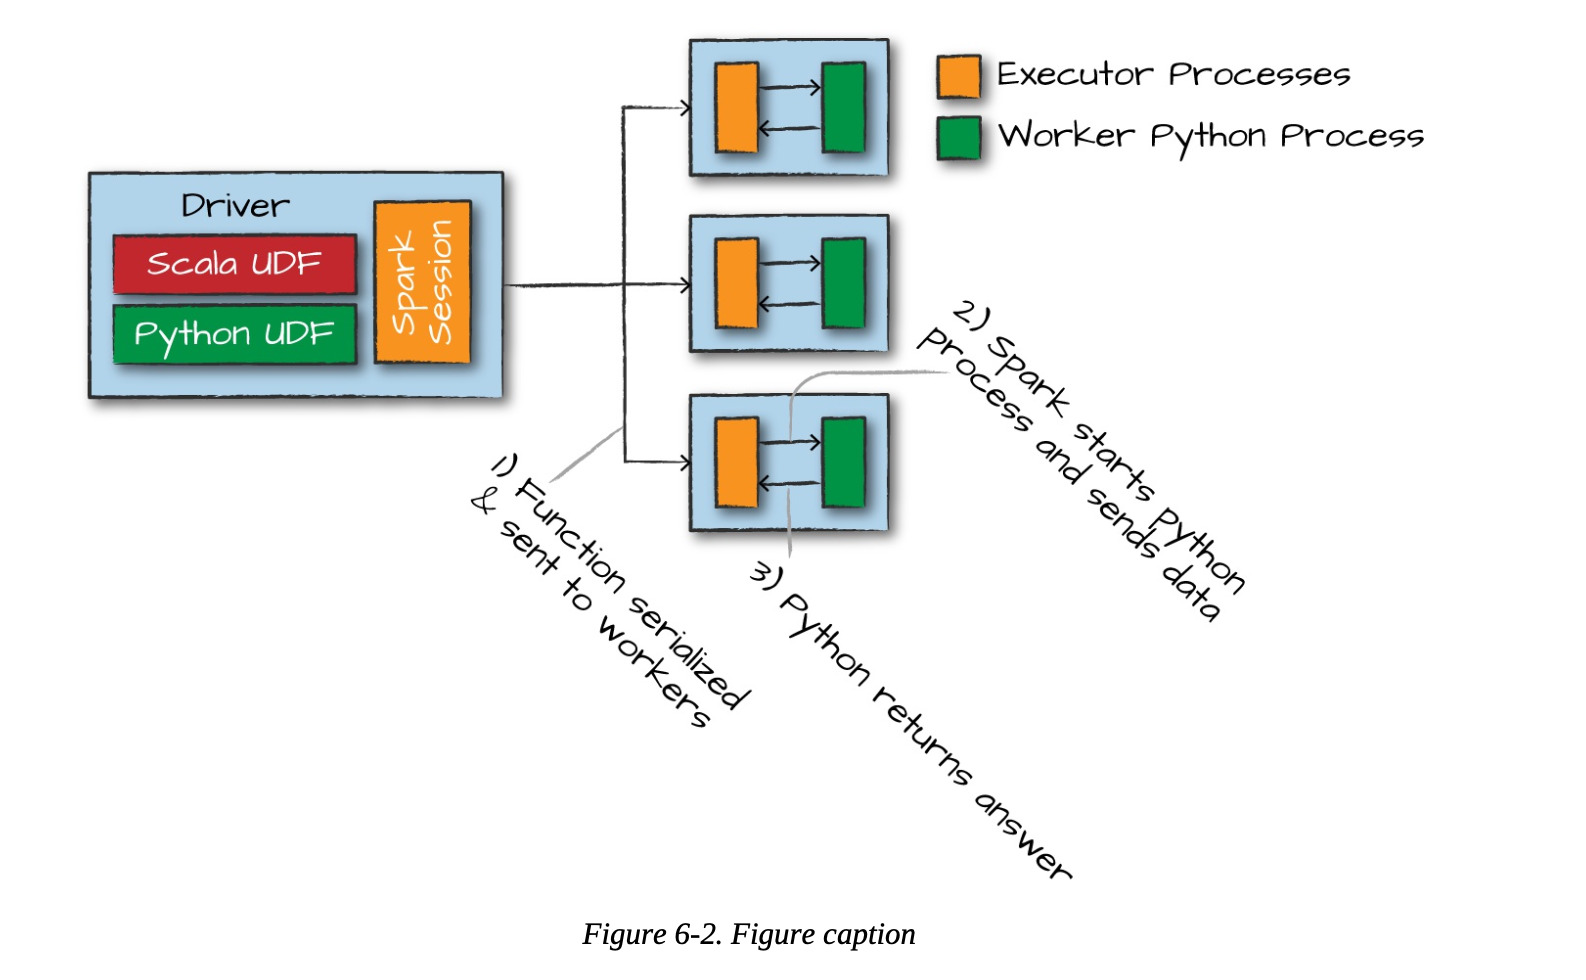

👉 Your diagram illustrates this process:

- **Driver:** holds the Spark session and the UDF definition.
- **Executors (orange):** JVM processes that manage Spark tasks.
- **Python Worker Processes (green):** launched per executor when running Python UDFs.

Steps:

1. Driver serializes the function and sends it to executors.
2. Executors start Python worker processes and pass row data to them.
3. Python workers compute results and return them back to executors.

### 🔎 Step 3: Register as a UDF and Use in DataFrame API

👉 Explanation:

- `udf(power3)` wraps your Python function for Spark.
- It runs **row by row** on workers.

In [9]:
from pyspark.sql.functions import udf, col

# Convert Python function into a Spark UDF
power3udf = udf(power3)

# Apply it on the DataFrame
udfExampleDF.select(power3udf(col("num")).alias("num_cubed")).show()


+---------+
|num_cubed|
+---------+
|        0|
|        1|
|        8|
|       27|
|       64|
+---------+



### 🔎 Step 4: Using UDFs in SQL Expressions

To call UDFs inside `selectExpr` or `spark.sql`, you must **register** them with Spark SQL.
👉 Now, `power3` behaves like a built-in SQL function.

In [10]:
# Register UDF with Spark SQL
spark.udf.register("power3", power3)

# Use in SQL-style expressions
udfExampleDF.selectExpr("power3(num)").show()


+-----------+
|power3(num)|
+-----------+
|          0|
|          1|
|          8|
|         27|
|         64|
+-----------+



### 🔎 Step 5: Why is this important?

- UDFs let you add **custom logic** Spark doesn’t provide out of the box.
- Useful for things like:
    - Custom math formulas
    - Text cleaning with regex
    - Integrating external Python libraries
- But:
    - ⚡ **Built-in Spark functions are faster** → prefer them first.
    - ✅ Use UDFs only when necessary.

---

✅ **In simple words**:

UDFs let you define your own logic in Python and run it in Spark, but they are slower than built-in functions. Use them when Spark doesn’t already have a function for your task.

# 📒 Typed UDFs

### 🔎 Step 1: Why do we need typed UDFs?

- By default, Spark assumes UDFs return **string type**, unless you explicitly specify.
- This can cause wrong schemas or unexpected results.
- To make UDFs safer and faster, always provide a **return type**.

In [12]:

# Apply it on the DataFrame
udfExampleDF.select(power3udf(col("num")).alias("num_cubed")).printSchema()

root
 |-- num_cubed: string (nullable = true)



### 🔎 Step 2: Defining a Typed UDF

We can pass the return type using `udf(function, returnType)`.

👉 Explanation:

- `DoubleType()` tells Spark the UDF will return floating-point numbers.
- Schema is now **accurate** and Spark can optimize better.

In [15]:
from pyspark.sql.types import LongType
from pyspark.sql.functions import col, udf

# Define Python function
def power3(double_value):
    return double_value ** 3

# Register as typed UDF (returns DoubleType)
power3udf = udf(power3, LongType())

# Apply UDF
udfExampleDF = spark.range(5).toDF("num")
udfExampleDF.select(col("num"), power3udf(col("num")).alias("num_cubed")).show()


+---+---------+
|num|num_cubed|
+---+---------+
|  0|        0|
|  1|        1|
|  2|        8|
|  3|       27|
|  4|       64|
+---+---------+



### 🔎 Step 3: Using Typed UDFs in SQL

In [16]:
# Register with return type
spark.udf.register("power3", power3, LongType())

# Use in SQL-style expression
udfExampleDF.selectExpr("num", "power3(num) as num_cubed").show()


+---+---------+
|num|num_cubed|
+---+---------+
|  0|        0|
|  1|        1|
|  2|        8|
|  3|       27|
|  4|       64|
+---+---------+



### 🔎 Step 4: Why is this important?

- Avoids schema inference mistakes.
- Makes your UDFs **safer** (you won’t accidentally return wrong types).
- Allows Spark to apply better **optimizations**.

---

✅ **In simple words**:

Always specify a return type when creating UDFs. It avoids errors and helps Spark run more efficiently.